# Data mining techniques: Assignment 2

## LambdaMART model training and evaluation

In [1]:
library("gbm")
library("xgboost")
library("StatRank")

Warning message:
“package ‘gbm’ was built under R version 3.4.4”Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3


# Scoring and Ranking functions

In [64]:
rank_prediction <- function(df){
    "
    Ranks search IDs according to prediction scores

    The dataframe given as a parameter 
    must contain the following columns
    in order to rank:
        - srch_id (the search IDs)
        - prediction (the prediction per row (higher score -> better rank))

    Other important columns are:
        - prop_id (for sorting the property IDs for the prediction file)
        - relevance (relevance score for calculating the NDCG of the test set)
    "
    
    #order.df <- df[,c("srch_id","prediction")]
    res <- df[order(df$srch_id,df$prediction,decreasing=c(FALSE,TRUE)),]
    
    rownames(res) <- NULL
    
    return(res)
}

ndcg_score <- function(i,data){
    group <- data[data[,"srch_id"] == i,]
    
    #dcg <- (2^group[,"relevance"] - 1) / log2((1:nrow(group))+1)
    #idcg <- (2^group[order(group$relevance,decreasing=TRUE),"relevance"] - 1) / log2((1:nrow(group))+1)
    #return(sum(dcg) / sum(idcg))
    
    return(Evaluation.NDCG(nrow(group):1,group[,"relevance"]))
}

ndcg_mean <- function(df){
    "
    Calculates the average ndcg score for a 
    given ensemble of ranked searches.

    The dataframe given as a parameter 
    must contain the following columns
    in order to calculate the ndcg score:
        - srch_id (the search IDs)
        - relevance (relevance score for calculating the NDCG of the test set)
    "
    ndcg <- sapply(unique(df[,"srch_id"]),data=df,FUN=ndcg_score)
    return(mean(ndcg,na.rm = TRUE))
}

In [65]:
# Test implementation

set.seed(1234)

srch_id <- c(rep(1,6),rep(2,6),3)
prop_id <- 1:13
prediction <- c(4,3,5,6,1,2,sample(1:6,replace=F),1)
relevance <- c(5,1,1,0,0,0,sample(c(5,1,0,0,0,0),replace=F),0)

df <- data.frame(srch_id=srch_id,prop_id=prop_id,prediction=prediction,relevance=relevance)

df

ranking <- rank_prediction(df)

ranking

ndcg_mean(ranking)

srch_id,prop_id,prediction,relevance
1,1,4,5
1,2,3,1
1,3,5,1
1,4,6,0
1,5,1,0
1,6,2,0
2,7,1,5
2,8,4,1
2,9,3,0
2,10,2,0


srch_id,prop_id,prediction,relevance
1,4,6,0
1,3,5,1
1,1,4,5
1,2,3,1
1,6,2,0
1,5,1,0
2,12,6,0
2,11,5,0
2,8,4,1
2,9,3,0


[1] 0.4401753

# Load the data

In [4]:
# Memory efficient column specific data frame loading functions
col_list <- function(names,selected,df){
    res <- c(1:length(names))
    res[] <- "NULL"
        
    for(i in 1:length(selected)){
        res[names == selected[i]] <- df[selected[i],1]
    }
    
    return(res)
}

load_part <- function(path,nrows = -1,skip = 1,colClasses = NA){
    namecols <- colClasses
    if(length(namecols) > 1 || !is.na(namecols)){
        namecols[colClasses != "NULL"] <- NA
    }
    
    names <- colnames(read.csv(trainPath,nrows = 1,colClasses=namecols))
    df <- read.csv(trainPath,header=F,skip=skip,nrows = nrows,colClasses=colClasses,
                   na.strings=c("NA","NULL"))
    
    colnames(df) <- names
    
    return(df)
}

In [5]:
trainPath <- "/home/kevin/data_mining/data/assignment2/Balanced_Data_DM/underTrain.csv"
validPath <- "/home/kevin/data_mining/data/assignment2/Balanced_Data_DM/underValidation.csv"
testPath <- "/home/kevin/data_mining/data/assignment2/Split_Data_DM/mod_test.csv"

trainNames <- colnames(read.csv(trainPath,nrows = 1))

# Initialize types to numeric
types <- c(1:length(trainNames))
types[] <- "numeric"

# Initialize type dataframe
types <- data.frame(types=types,stringsAsFactors=FALSE)
rownames(types) <- trainNames

# Set types manually
types[c(1,2,3,6,7,17,55,56),] = "factor"

types

,types
srch_id,factor
site_id,factor
visitor_location_country_id,factor
visitor_hist_starrating,numeric
visitor_hist_adr_usd,numeric
prop_country_id,factor
prop_id,factor
prop_starrating,numeric
prop_review_score,numeric
prop_brand_bool,numeric


In [6]:
columns <- col_list(trainNames,trainNames,types)

train <- read.csv(trainPath,colClasses=columns)
valid <- read.csv(validPath,colClasses=columns)

full <- rbind(train,valid)

test <- read.csv(testPath,colClasses=columns)

In [7]:
head(full)

srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,⋯,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,date_hour,date_month,date_year,relevance,ignored_bool
49766,5,219,NA,NA,219,88389,4,4.0,0,⋯,0,0,0,NA,0,14,6,2013,0,1
49766,5,219,NA,NA,219,100549,3,4.5,0,⋯,0,0,0,NA,0,14,6,2013,0,1
49766,5,219,NA,NA,219,108197,3,4.0,1,⋯,0,0,1,NA,0,14,6,2013,1,0
49768,5,219,NA,NA,219,97076,3,4.5,1,⋯,0,0,1,NA,0,15,6,2013,1,0
49768,5,219,NA,NA,219,100485,4,4.0,1,⋯,0,0,0,NA,0,15,6,2013,0,1
49769,5,219,NA,NA,55,11473,4,4.0,1,⋯,0,0,1,308.65,1,11,6,2013,5,0


# Model training

## Train lambdaMART using GBM

In [76]:
gbm.train <- subset(full, select=c(-position,-click_bool,-gross_bookings_usd,-booking_bool,-ignored_bool,
                                    -visitor_hist_starrating,-visitor_hist_adr_usd))

head(gbm.train)

# price_usd+prop_starrating+prop_location_score1+prop_location_score2

gbm.model <- gbm(relevance~ price_usd+prop_location_score2+random_bool,
                data=gbm.train,
                distribution=list(   # loss function:
                  name='pairwise',   # pairwise
                  metric="ndcg",     # ranking metric:
                  group="srch_id"),    # column indicating query groups
                n.trees=1000,        # number of trees
                keep.data=TRUE,      # store copy of input data in model
                verbose = FALSE,     # don't print progress
                n.cores = 1)         # number of cores used

srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,⋯,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,date_hour,date_month,date_year,relevance
49766,5,219,219,88389,4,4.0,0,3.09,0.0190,⋯,0,0,0,0,0,0,14,6,2013,0
49766,5,219,219,100549,3,4.5,0,3.04,0.3747,⋯,0,0,0,0,0,0,14,6,2013,0
49766,5,219,219,108197,3,4.0,1,1.39,0.1826,⋯,0,0,0,0,0,0,14,6,2013,1
49768,5,219,219,97076,3,4.5,1,1.39,0.0458,⋯,0,0,0,0,0,0,15,6,2013,1
49768,5,219,219,100485,4,4.0,1,1.95,0.0770,⋯,0,0,0,0,0,0,15,6,2013,0
49769,5,219,55,11473,4,4.0,1,2.64,0.0824,⋯,0,0,0,0,0,0,11,6,2013,5


# Model evaluation

In [77]:
gbm.test <- subset(test, select=c(-position,-click_bool,-gross_bookings_usd,-booking_bool,-ignored_bool,
                                    -visitor_hist_starrating,-visitor_hist_adr_usd))

predictions <- predict(gbm.model,gbm.test,n.trees=1000)

predictions.df <- data.frame(srch_id=as.numeric(as.character(gbm.test$srch_id)),
                             prop_id=as.numeric(as.character(gbm.test$prop_id)),
                             prediction=predictions,relevance=gbm.test$relevance)

print("Now ranking")

ranking <- rank_prediction(predictions.df)

ranking

print("Now scoring")

ndcg_mean(ranking)

[1] "Now ranking"


srch_id,prop_id,prediction,relevance
1,29604,0.271357451,0
1,30184,0.271357451,0
1,53341,0.271357451,0
1,74474,0.271357451,0
1,88218,0.271357451,0
1,95307,0.271357451,0
1,56880,0.264543071,0
1,88096,0.175445015,0
1,107872,0.044700829,0
1,893,0.012681104,0


[1] "Now scoring"


[1] 0.4141533

,var,rel.inf
prop_location_score2,prop_location_score2,100
price_usd,price_usd,0
random_bool,random_bool,0


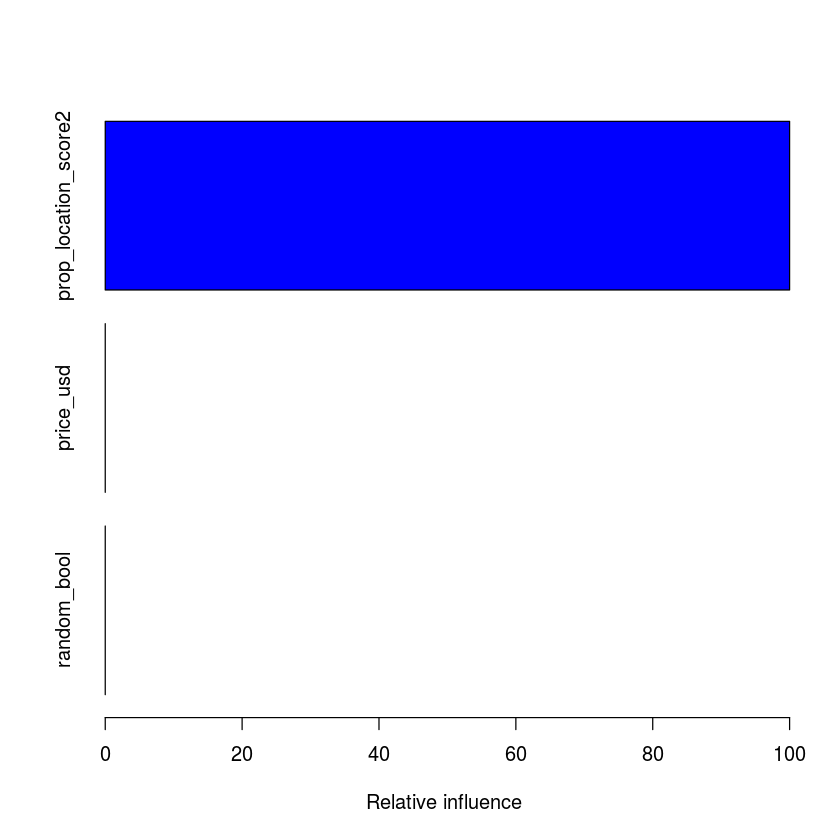

In [78]:
summary(gbm.model)